# pystan part 1
Lets start modeling an univariate linear regression:
$y \sim N(\alpha + \beta X,\sigma)$

In [2]:
%load_ext autoreload
%autoreload 2
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
sns.set()
np.random.seed(111)

from lib import generate_data, plot_trace

Lets start generating the data we want to model. In this case `generate_data` is just a wrapper of `np.random.normal`

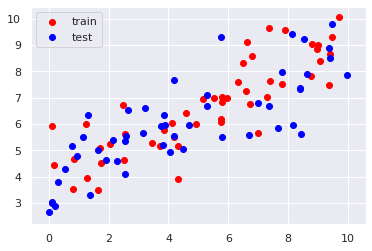

In [4]:
N = 100 # num of points
xN, yN = generate_data(N=N,alpha=4.0, beta=0.5, sigma=1.0)

x = xN[:50]  # lets use half to `training`
y = yN[:50]

x_t = xN[50:] # and the rest for an inference experiment at the end
y_t = yN[50:]

plt.scatter(x, y, color="red", label="train")
plt.scatter(x_t, y_t, color="blue", label="test")
plt.legend()
plt.show()

Define the data dictionary and the model, importing the script

In [5]:
data = {'N': len(x), 'x': x, 'y': y} # we make the dictionary for stan
sm = pystan.StanModel(file="../stan_scripts/linear.stan") # and load the model 

fit = sm.sampling(
    data=data, 
    iter=1000, 
    chains=4, 
    warmup=500, 
    thin=1, 
    seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_145e881d39a92f1efc9f0eb0440f1378 NOW.


Sampling method params:
 - iter : number of samples from each markov chain
 - chains : num of chains from where samples will 
    be combined (more chains better, but takes more time)
 - warmup : num samples to be discarded at the begining (low chance of reaching equilibrium)

In [6]:
print(fit) # we can get a summary for each parameter we are estimating :

Inference for Stan model: anon_model_145e881d39a92f1efc9f0eb0440f1378.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.93  9.8e-3   0.28   3.36   3.75   3.93   4.12   4.48    831    1.0
beta    0.52  1.7e-3   0.05   0.42   0.49   0.52   0.55   0.62    840    1.0
sigma   0.96  3.2e-3    0.1   0.78   0.89   0.95   1.02   1.18    984    1.0
lp__  -21.79    0.05   1.24 -24.98 -22.38 -21.46 -20.87 -20.36    742   1.01

Samples were drawn using NUTS at Sun Jun 14 18:07:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


- `lp__` :log posterior density . convergence means more confidence. 
- `n_eff`:effective sample size (https://en.wikipedia.org/wiki/Effective_sample_size)
- `Rhat`: Gelman-Rubin convergence statistic (1.0 = convergence)



In [7]:
summary_dict = fit.summary()
# we can transform the results into a pandas dataframe for easier handling
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

In [8]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.929125,0.009812,0.282810,3.355608,3.748165,3.929399,4.116739,4.481899,830.788599,1.001729
beta,0.520714,0.001660,0.048111,0.424173,0.488773,0.520170,0.552554,0.617900,839.874733,1.001743
sigma,0.956003,0.003168,0.099390,0.782807,0.888130,0.946874,1.015801,1.182782,984.409500,1.000965
lp__,-21.790232,0.045691,1.244226,-24.984200,-22.383114,-21.462382,-20.870600,-20.357225,741.537407,1.007270


In [9]:
# these are the  traces associated to each parameter we want to model
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

# and we can obtain their average 
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

In [10]:
traces_size = len(alpha)
print(traces_size)

2000


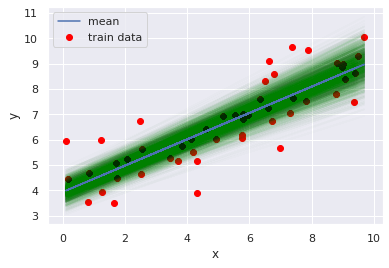

In [17]:
# we can visualize the amount of uncertanty associated to the result
# by plotting the traces for sample of x

# lets plot the traces
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(traces_size):
    plt.plot(x, alpha[i] + beta[i] * x, color='green', 
           alpha=0.01 )

# and now the line associated with the mean values of the traces
plt.plot(x, alpha_mean + beta_mean * x, label="mean")

#
plt.scatter(x, y, color="red", label="train data")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


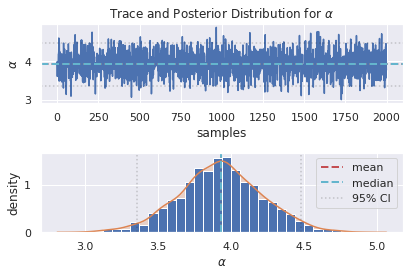

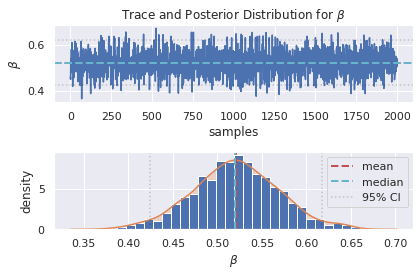

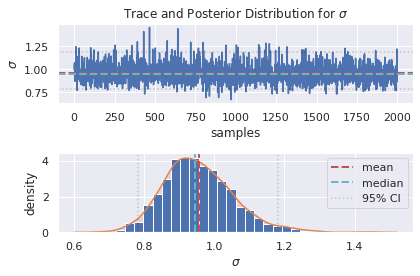

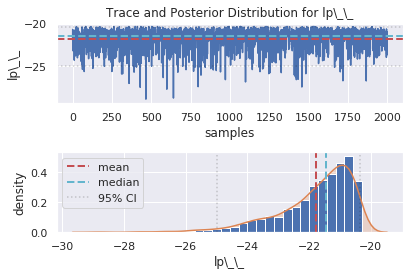

In [18]:
# we can takea a look at each variable and compute their density

plot_trace(alpha, r'$\alpha$') 
plt.show()
plot_trace(beta, r'$\beta$') 
plt.show()
plot_trace(sigma, r'$\sigma$') 
plt.show()
plot_trace(lp, r'lp\_\_') 
plt.show()

# Comparing against maximum likelihood

In [19]:
# lets use a vanilla lineal regression from sklearn
regression = LinearRegression()
# we pass the same training data
linear_model = regression.fit(x[:,np.newaxis],y)

# some results:
print("intercept", linear_model.intercept_)
print("coef", linear_model.coef_)

# we evaluate on the test data (xt, yt)
pred_y = linear_model.predict(x_t.reshape(-1,1))
mse_ml = mean_squared_error(y_t, pred_y)
r2_ml  = r2_score(y_t, pred_y)

print("mse", mse_ml)
print("r2",r2_ml)

intercept 3.922826116035497
coef [0.52113123]
mse 1.170553989238649
r2 0.6150483464294924


In [20]:
# we can do the same for the bayesian model (using the mean values)

pred_y_bayes =  alpha_mean + beta_mean * x_t
mse_bayes = mean_squared_error(y_t, pred_y_bayes)
r2_bayes  = r2_score(y_t, pred_y_bayes)

print("mse", mse_bayes)
print("r2",r2_bayes)


mse 1.1723493915599255
r2 0.6144579054086137


### Lets see both lines

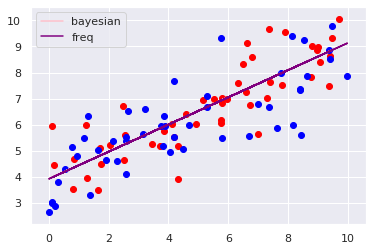

In [22]:
plt.plot(x_t, alpha_mean + beta_mean * x_t, label="bayesian", c="pink")
plt.plot(x_t, linear_model.intercept_ + linear_model.coef_ * x_t, label="freq", c="purple")

plt.scatter(x, y, color="red")
plt.scatter(x_t, y_t, color="blue")
plt.legend()
plt.show()